# Graph-Based Modeling of a School Social Network

## Assignment 1

### Part 1: Build a Friendship Network

In [2]:
# Import needed Libraries
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import heapq

In [3]:
# Constants like num of students, features like years,branches,clubs,gender

NUM_STUDENTS = 500
YEARS = ['Y22', 'Y23', 'Y24']
BRANCHES = ['Che', 'MTH', 'Mech', 'CSE', 'EE']
CLUBS = ['Chess', 'Badminton', 'Sleeping', 'Gaming', 'Drama', 'Robotics', 'Books', 'Coding']
GENDER = ['Male','Female']
SIMILARITY_THRESHOLD = 4
POPULARITY_PERCENTAGE = 0.1
MAX_CLUB_SIZE = 30
MAX_SIMILARITY = 10
MAX_FRIENDS_PER_STUDENT = 30
friend_counts = defaultdict(int)

### Part 1: Build the Friendship Network

In [4]:
def generate_students():
    students = {}
    club_membership = defaultdict(list)
    popular_students = set(random.sample(range(NUM_STUDENTS), int(NUM_STUDENTS * POPULARITY_PERCENTAGE)))

    for i in range(NUM_STUDENTS):
        year = random.choice(YEARS)
        branch = random.choice(BRANCHES)
        gender = random.choice(GENDER)
        num_clubs = random.randint(0, 3)
        clubs = []

        for _ in range(num_clubs):
            possible_clubs = [club for club in CLUBS if len(club_membership[club]) < MAX_CLUB_SIZE]
            if not possible_clubs:
                break
            chosen_club = random.choice(possible_clubs)
            clubs.append(chosen_club)
            club_membership[chosen_club].append(i)

        students[i] = {
            'year': year,
            'branch': branch,
            'gender': gender,
            'clubs': set(clubs),
            'popular': i in popular_students
        }
    return students

# Similarity scoring

def compute_similarity(s1, s2):
    score = 0
    if s1['year'] == s2['year']:
        score += 1
    if s1['branch'] == s2['branch']:
        score += 1
    if s1['gender'] == s2['gender']:
        score += 2
    score += (2*len(s1['clubs'] & s2['clubs']))
    return score

# Graph generation

def generate_friendship_graph(students):
    G = nx.Graph()
    for i, data in students.items():
        G.add_node(i, **data)

    for i in range(NUM_STUDENTS):
        for j in range(i + 1, NUM_STUDENTS):
            sim = compute_similarity(students[i], students[j])
            if sim < SIMILARITY_THRESHOLD:
                continue

            base_prob = sim / MAX_SIMILARITY

            if students[i]['popular'] or students[j]['popular']:
                base_prob *= 1.5

            mutual_friends = set(G.neighbors(i)) & set(G.neighbors(j))
            clustering_boost = 1 + 0.1 * len(mutual_friends)
            prob = min(base_prob * clustering_boost, 1.0)

            if random.random() < prob:
                # Normalize sim to weight between 1 and 10 (lower is stronger)
                if friend_counts[i] < MAX_FRIENDS_PER_STUDENT and friend_counts[j] < MAX_FRIENDS_PER_STUDENT:
                    friend_counts[i] += 1
                    friend_counts[j] += 1
                    weight = int(round(10 - (sim / MAX_SIMILARITY) * 9)) + 1
                    weight = min(max(weight, 1), 10)
                    G.add_edge(i, j, weight=weight)

    return G

def get_adjacency_list(G):
    adj = defaultdict(list)
    for u, v, data in G.edges(data=True):
        adj[u].append((v, data['weight']))
        adj[v].append((u, data['weight']))  # Undirected graph
    return adj


### Part 2: Analyze Friend Groups

In [5]:
# Connected components

def analyze_friend_groups(G):
    components = list(nx.connected_components(G))
    sizes = [len(c) for c in components]
    print("Friend Groups: ", len(components))
    print("Smallest Group: ", min(sizes))
    print("Largest Group: ", max(sizes))
    return components

### Part 3: Find Closest Friendship Paths

In [6]:
# Dijkstra

def dijkstra(G, start):
    distances = {node: float('inf') for node in G.nodes}
    prev = {node: None for node in G.nodes}
    distances[start] = 0
    pq = [(0, start)]
    while pq:
        dist, current = heapq.heappop(pq)
        for neighbor in G.neighbors(current):
            weight = G[current][neighbor]['weight']
            alt = dist + weight
            if alt < distances[neighbor]:
                distances[neighbor] = alt
                prev[neighbor] = current
                heapq.heappush(pq, (alt, neighbor))
    return distances, prev

def reconstruct_path(prev, target):
    path = []
    while target is not None:
        path.append(target)
        target = prev[target]
    return path[::-1]

# A* with heuristic

def heuristic(s1, s2):
    return 0 if s1['year'] == s2['year'] else 5

def astar(G, start, goal, students):
    open_set = [(0, start)]
    g_score = {node: float('inf') for node in G.nodes}
    g_score[start] = 0
    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = heuristic(students[start], students[goal])
    prev = {node: None for node in G.nodes}

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            break

        for neighbor in G.neighbors(current):
            weight = G[current][neighbor]['weight']
            tentative_g = g_score[current] + weight
            if tentative_g < g_score[neighbor]:
                prev[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic(students[neighbor], students[goal])
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return reconstruct_path(prev, goal)

### Bonus: Detect Social Bridges

In [7]:
# Bridge detection

def detect_bridges(G):
    critical_nodes = []
    for node in G.nodes:
        G_copy = G.copy()
        G_copy.remove_node(node)
        if len(list(nx.connected_components(G_copy))) > len(list(nx.connected_components(G))):
            critical_nodes.append(node)
    print("Bridge Nodes Detected:", critical_nodes[:5])  # Show top 5
    return critical_nodes

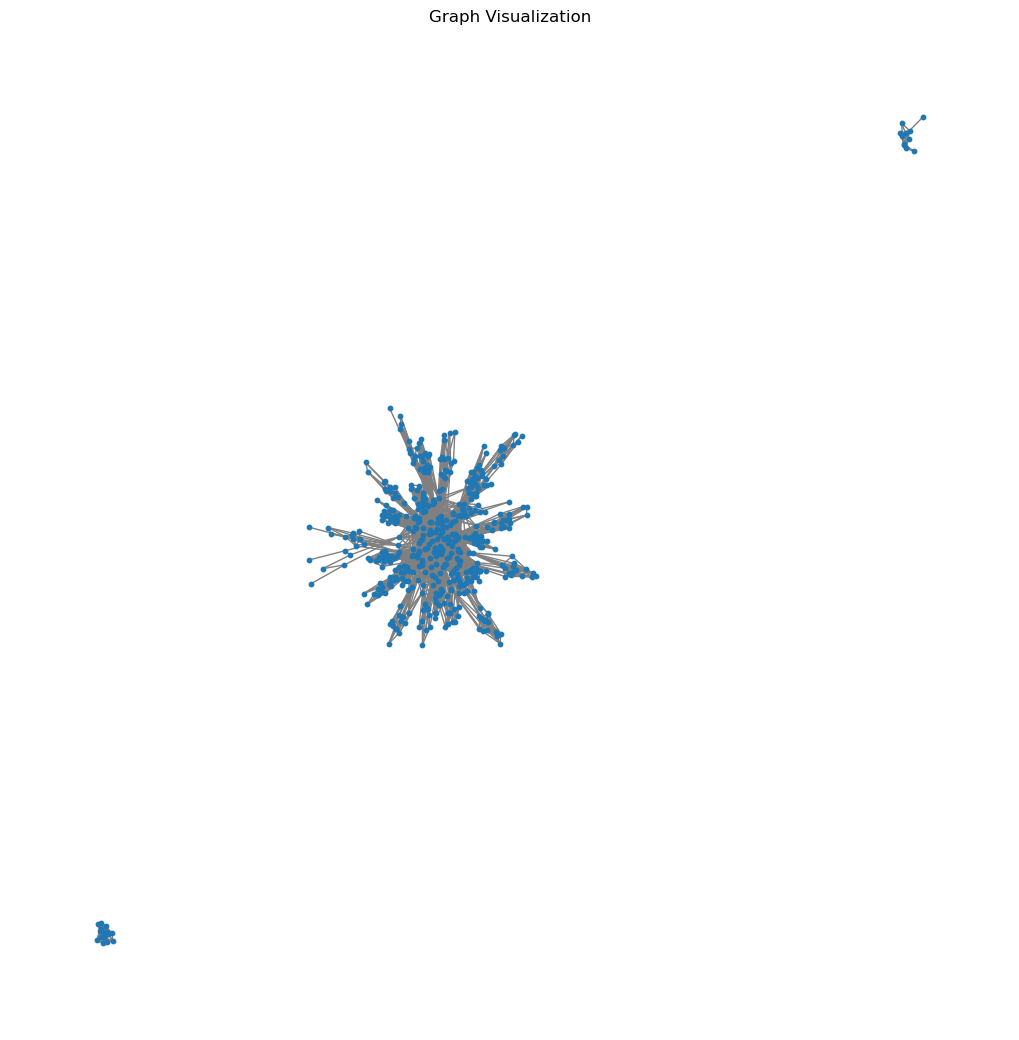

Friend Groups:  3
Smallest Group:  11
Largest Group:  474
Dijkstra path from 249 to 458 (Component 1): [249, 458]


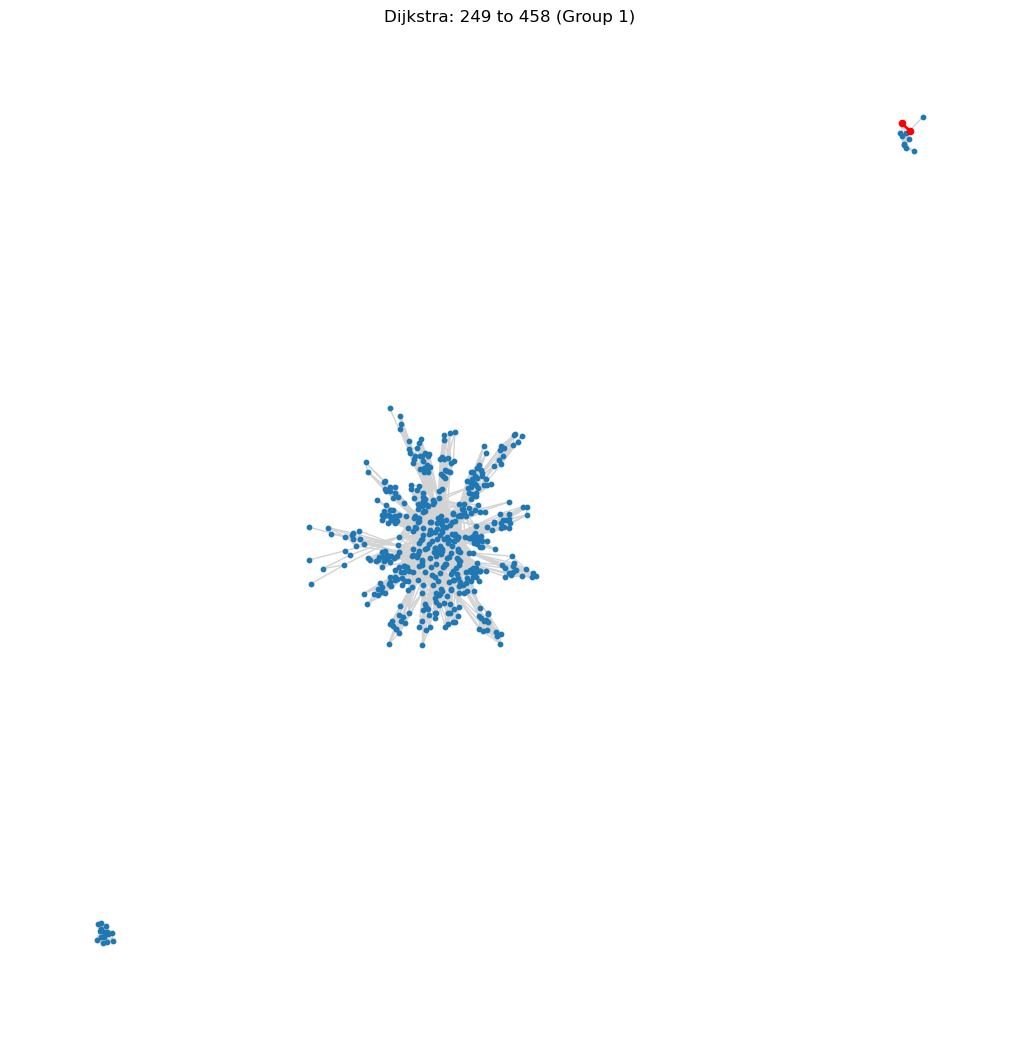

A* path from 249 to 458 (Component 1): [249, 458]


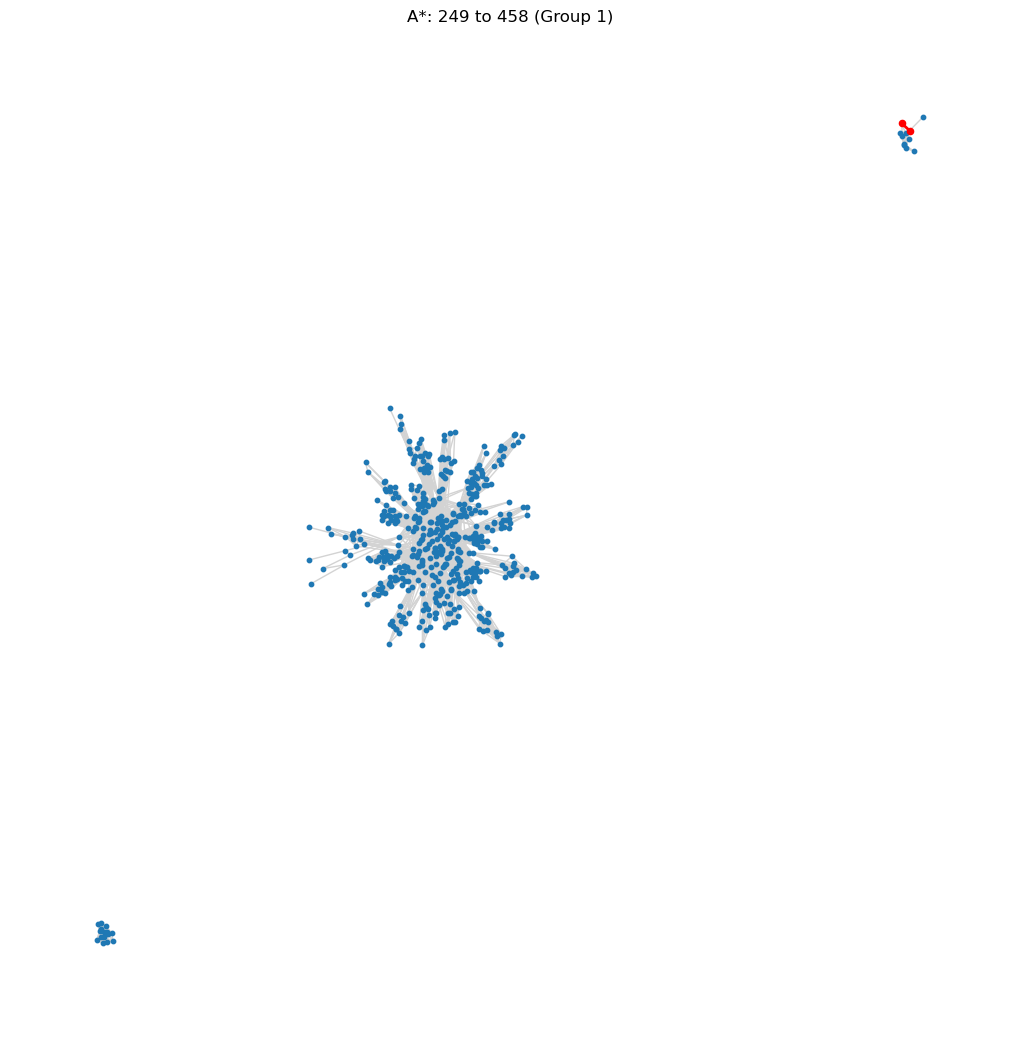

Dijkstra path from 257 to 422 (Component 2): [257, 422]


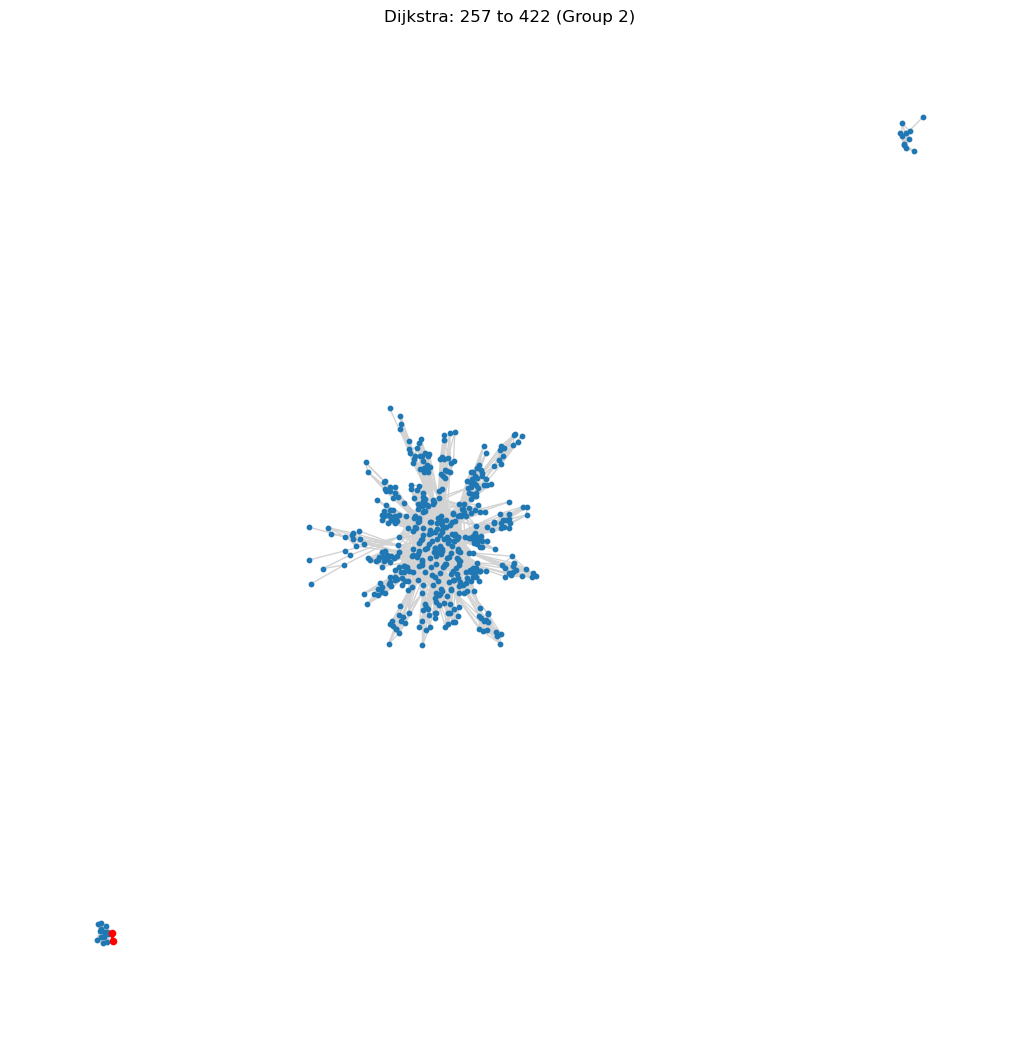

Dijkstra path from 139 to 112 (Component 3): [139, 117, 112]


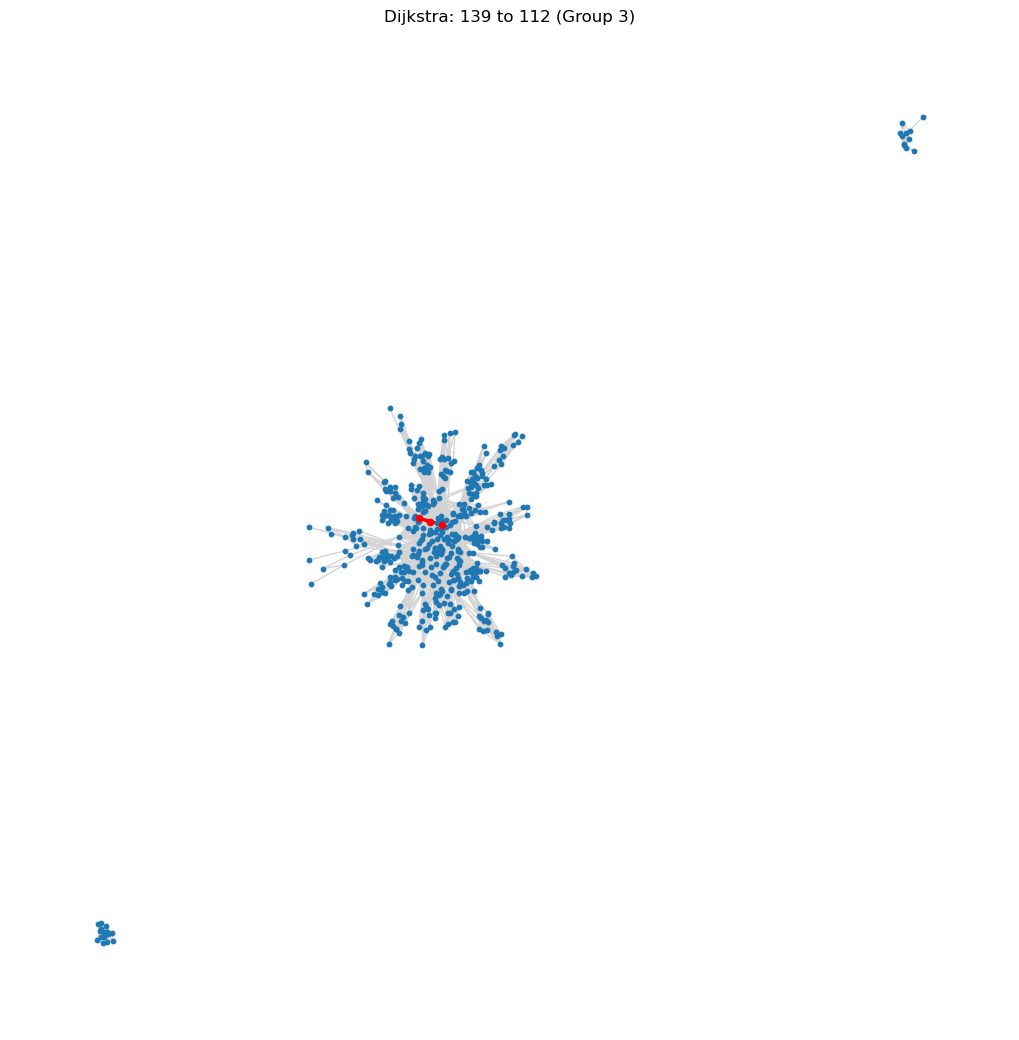

Bridge Nodes Detected: [154, 249, 295, 332, 397]


In [8]:
# Visualizations

def draw_graph(G, title='Graph Visualization'):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=10, edge_color='gray')
    plt.title(title)
    plt.show()

def draw_path(G, path, title='Shortest Path'):
    path_edges = list(zip(path, path[1:]))
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=10, edge_color='lightgray')
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='red', node_size=20)
    plt.title(title)
    plt.show()

# Master routine

def main():
    students = generate_students()
    G = generate_friendship_graph(students)
    draw_graph(G)
    
    components = analyze_friend_groups(G)

    # Shortest paths across random connected components
    connected_components = [list(c) for c in nx.connected_components(G) if len(c) > 1]

    # Pick 5 different components randomly (or fewer if not enough)
    random_components = random.sample(connected_components, min(5, len(connected_components)))

    for i, component in enumerate(random_components):
        if len(component) < 2:
            continue  # Skip too-small components
        u, v = random.sample(component, 2)
        dist, prev = dijkstra(G, u)
        path = reconstruct_path(prev, v)
        print(f"Dijkstra path from {u} to {v} (Component {i+1}): {path}")
        draw_path(G, path, f"Dijkstra: {u} to {v} (Group {i+1})")

        if i == 0:
            a_star_path = astar(G, u, v, students)
            print(f"A* path from {u} to {v} (Component {i+1}): {a_star_path}")
            draw_path(G, a_star_path, f"A*: {u} to {v} (Group {i+1})")
    detect_bridges(G)

if __name__ == "__main__":
    main()